本人作为黄渤的粉丝，《一出好戏》当然是必看无疑呀。这里通过猫眼的影评来分析下网友对它的反馈。

## 爬取数据

这里通过去请求猫眼的API来抓取数据，借助的工具是 `requests` 。

这里简单说下猫眼影评的API：

```
http://m.maoyan.com/mmdb/comments/movie/1203084.json?_v_=yes&offset=1
```

其中，`1203084` 表示猫眼中该电影的id（可以从猫眼官网得到），`offset`表示偏移量，简单理解就是页数。

In [1]:
import requests
import pandas as pd


base_url = "http://m.maoyan.com/mmdb/comments/movie/1203084.json?_v_=yes&offset="

# 爬取每一页的评论
def crawl_one_page_data(url):
    headers = {
    "User-Agent":"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    
    # 页面访问不成功
    if response.status_code != 200: 
        return []
    
    return response.json()

# 解析每一个获得的结果
def parse(data):
    result = []
    # 影评数据在 cmts 这个 key 中
    comments = data.get("cmts")
    
    if not comments:
        return []
    
    for cm in comments:
        yield [cm.get("id"), # 影评id
               cm.get("time"), # 影评时间
               cm.get("score"), # 影评得分
               cm.get("cityName"), # 影评城市 
               cm.get("nickName"), # 影评人 
               cm.get("gender"), # 影评人性别，1 表示男性，2表示女性
               cm.get("content")] # 影评内容

# 爬取影评
def crawl_film_review(total_page_num=100):
    data = []
    for i in range(1, total_page_num + 1):
        url = base_url + str(i)
        crawl_data = crawl_one_page_data(url)
        if crawl_data:
            data.extend(parse(crawl_data))
    return data

columns=["id", "time", "score", "city", "nickname", "gender", "content"]
df = pd.DataFrame(crawl_film_review(4000), columns=columns)
# 将性别映射后的数字转为汉字
df["gender"] = np.where(df.gender==1, "男性", "女性")
# 根据id去除重复影评
df = df.drop_duplicates(subset=["id"])
df.head()

,id,time,score,city,nickname,gender,content
0,1034383161,2018-08-11 11:33,5.0,北京,Kuh247770220,女性,好看好看好看
1,1034383157,2018-08-11 11:33,0.5,苏州,Xqz544302690,男性,我表示还不如在家里看荒野求生 反正都在一个岛上 无聊！
2,1034386930,2018-08-11 11:32,5.0,厦门,欧祺松,女性,棒极了，结局完美
3,1034387472,2018-08-11 11:32,5.0,武汉,gYK288217555,女性,讲述了绝境中的人性，幽默搞笑，让人深思
4,1034383130,2018-08-11 11:32,5.0,铜仁,简宇涵520520,女性,非常好看，搞笑、互帮互助


In [2]:
# 保存抓取数据，方便后续使用。
df.to_csv("《一出好戏》影评_1000.csv", index=False)
df = pd.read_csv("《一出好戏》影评_1000.csv", encoding="gbk")
df.head()

,id,time,score,city,nickname,gender,content
0,1034383161,2018-08-11 11:33,5.0,北京,Kuh247770220,女性,好看好看好看
1,1034383157,2018-08-11 11:33,0.5,苏州,Xqz544302690,男性,我表示还不如在家里看荒野求生 反正都在一个岛上 无聊！
2,1034386930,2018-08-11 11:32,5.0,厦门,欧祺松,女性,棒极了，结局完美
3,1034387472,2018-08-11 11:32,5.0,武汉,gYK288217555,女性,讲述了绝境中的人性，幽默搞笑，让人深思
4,1034383130,2018-08-11 11:32,5.0,铜仁,简宇涵520520,女性,非常好看，搞笑、互帮互助


## 性别分析

In [5]:
from pyecharts import Pie

# 求出不同性别出现的次数
gender_count = df.gender.value_counts().to_dict()

pie = Pie("性别分析")
pie.add(name="", attr=gender_count.keys(), value=gender_count.values(), is_label_show=True)
pie

看下结果，参与评价的用户中，女性用户远高于男性用户，黄渤的个人魅力竟然迷倒了这么多妹子😘😘。

## 评分分布

In [6]:
from pyecharts import Bar

# 求出不同评分出现的次数
score_count = df.score.value_counts().sort_index()
score_list = score_count.index.tolist()
count_list = score_count.tolist()

bar = Bar("评分分布", width=450, height=450)
bar.add("", score_list, count_list)
bar

可以看到，五分好评还是相当多的。这意味着大众还是很喜欢黄渤的这个处女作的😉。

## 不同性别评分的差异

In [7]:
# 求出不同性别评分的均值
sex_score_mean = df.groupby(["gender"])["score"].mean().to_dict()

bar = Bar("不同性别评分的差异", width=450, height=450)

bar.add("", list(sex_score_mean.keys()), list(sex_score_mean.values()), is_stack=True)
bar

可以看到，男性和女性的平均评分相差不多，女性能略高一丢丢😁

## 一线城市与二线城市的评分差异

In [12]:
# 求出不同城市评分的均值

city_list = ["北京", "上海", "西安", "太原"]

gender_city_score_mean = df[df.city.isin(city_list)].groupby(["gender", "city"], as_index=False)["score"].mean()

city_data, city_index = pd.factorize(gender_city_score_mean.city)
gender_data, gender_index = pd.factorize(gender_city_score_mean.gender)
data = list(zip(city_data, gender_data, gender_city_score_mean.score.values))

In [15]:
from pyecharts import Bar3D

bar3d = Bar3D("一线城市与二线城市的评分差异", width=650, height=450)

range_color = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8', '#ffffbf',
               '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
bar3d.add("", city_index, gender_index, data,
          is_visualmap=True, visual_range=[0, 5],
          visual_range_color=range_color, grid3d_width=150, grid3d_depth=80, is_grid3d_rotate=False)
bar3d

可以看到，一线城市（北京、上海）的平均评分略高于二线城市（太原、西安）的评分。

## 影评词云图

再来看看通过大家的评论能够得到怎么样的云图。

Building prefix dict from C:\soft\py3\lib\site-packages\jieba\dict.txt ...
DEBUG:jieba:Building prefix dict from C:\soft\py3\lib\site-packages\jieba\dict.txt ...
Loading model from cache C:\Users\WANGWE~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\WANGWE~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.4429686069488525 seconds.
DEBUG:jieba:Loading model cost 1.4429686069488525 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


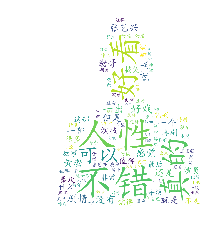

In [14]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import jieba
import matplotlib.pyplot as plt

# 将分词后的结果以空格连接
words = " ".join(jieba.cut(df.content.str.cat(sep=" ")))

# 导入背景图
backgroud_image = plt.imread("黄渤.jpg")

# 设置停用词
stopwords = STOPWORDS
stopwords.add("电影")

wc = WordCloud(stopwords=stopwords,
               font_path="C:/Windows/Fonts/simkai.ttf",  # 解决显示口字型乱码问题
               mask=backgroud_image, background_color="white", max_words=100)

my_wc = wc.generate_from_text(words)

ImageColorGenerator

image_colors = ImageColorGenerator(backgroud_image)

plt.imshow(my_wc )
# plt.imshow(my_wc.recolor(color_func=image_colors), )
plt.axis("off")
plt.show()